In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data.dataloader import Dataset, DataLoader

import cv2
import os
import numpy as np
import glob
import random
import matplotlib.pyplot as plt

#SRCNN

In [ ]:
n1,n2,n3 = 128, 64, 3
f1,f2,f3 = 9,3,5
upscale_factor = 3
#To avoid border effects during training, all the convolutional layers have no padding, and the network
#produces a smaller output ((fsub − f1 − f2 − f3 + 3)2 × c).

input_size = 33
output_size = input_size - f1 - f2 - f3 + 3

stride = 14

batch_size = 128
epochs = 200

path = "/content/drive/MyDrive/SRCNN/T91"
save_path = "/content/drive/MyDrive/SRCNN/torch_SRCNN_200EPOCHS.h5"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, img_paths, input_size, output_size, stride = 14, upscale_factor = 3):
    super(CustomDataset, self).__init__()

    self.img_paths = glob.glob(img_paths + '/' + '*.png')
    self.stride = stride
    self.upscale_factor = upscale_factor
    self.sub_lr_imgs = []
    self.sub_hr_imgs = []
    self.input_size = input_size
    self.output_size = output_size
    self.pad = abs(self.input_size - self.output_size) // 2 # 7

    print("Start {} Images Pre-Processing".format(len(self.img_paths)))
    for img_path in self.img_paths:
      img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
      #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

      # mod_crop
      h = img.shape[0] - np.mod(img.shape[0], self.upscale_factor)
      w = img.shape[1] - np.mod(img.shape[1], self.upscale_factor)
      img = img[:h, :w, :]

      # zoom_img
      label = img.astype(np.float32) / 255.0
      temp_input = cv2.resize(label, dsize=(0,0), fx = 1/self.upscale_factor, fy = 1/self.upscale_factor,
                              interpolation = cv2.INTER_AREA)
      input = cv2.resize(temp_input, dsize=(0,0), fx = self.upscale_factor, fy = self.upscale_factor,
                        interpolation = cv2.INTER_CUBIC)

      # Crop: img to sub_imgs
      for h in range(0, input.shape[0] - self.input_size + 1, self.stride):
        for w in range(0, input.shape[1] - self.input_size + 1, self.stride):
          sub_lr_img = input[h:h+self.input_size, w:w+self.input_size, :]
          sub_hr_img = label[h+self.pad:h+self.pad+self.output_size, w+self.pad:w+self.pad+self.output_size, :]

          sub_lr_img = sub_lr_img.transpose((2,0,1))
          sub_hr_img = sub_hr_img.transpose((2,0,1))
          #sub_lr_img = sub_lr_img.reshape(3, self.input_size, self.input_size)
          #sub_hr_img = sub_hr_img.reshape(3, self.output_size, self.output_size)

          self.sub_lr_imgs.append(sub_lr_img)
          self.sub_hr_imgs.append(sub_hr_img)
    print("Finish, Created {} Sub-Images".format(len(self.sub_lr_imgs)))
    self.sub_lr_imgs = np.asarray(self.sub_lr_imgs)
    self.sub_hr_imgs = np.asarray(self.sub_hr_imgs)


  def __len__(self):
    return len(self.sub_lr_imgs)

  def __getitem__(self, idx):
    lr_img = self.sub_lr_imgs[idx]
    hr_img = self.sub_hr_imgs[idx]
    return lr_img, hr_img

In [ ]:
train_dataset = CustomDataset(path, input_size, output_size)

Start 91 Images Pre-Processing
Finish, Created 21884 Sub-Images


##원본 HR 고화질 이미지 확인

(132, 150, 3)


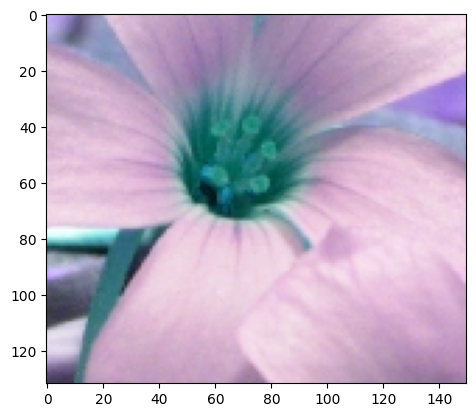

In [ ]:
img = cv2.imread(train_dataset.img_paths[12])
print(img.shape)
plt.imshow(img)

##paired 이미지 패치 확인 - 저해상도, 고해상도


5109


Text(0.5, 1.0, 'hr_img')

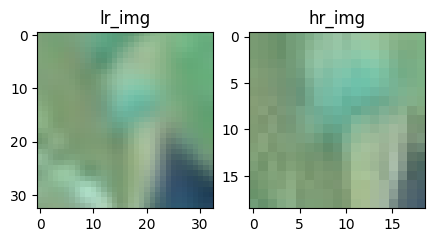

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (5,5))
idx = random.randint(0, len(train_dataset.sub_lr_imgs))

axes[0].imshow(train_dataset.sub_lr_imgs[idx].transpose(1,2,0))
axes[1].imshow(train_dataset.sub_hr_imgs[idx].transpose(1,2,0))

print(idx)
axes[0].set_title('lr_img')
axes[1].set_title('hr_img')

##model 선언

In [ ]:
class SRCNN(nn.Module):
  def __init__(self, kernel_list, filters_list, num_channels = 3):
    super(SRCNN, self).__init__()

    f1,f2,f3 = kernel_list
    n1,n2,n3 = filters_list

    self.conv1 = nn.Conv2d(num_channels, n1, kernel_size = f1)
    self.conv2 = nn.Conv2d(n1, n2, kernel_size = f2)
    self.conv3 = nn.Conv2d(n2, num_channels, kernel_size = f3)
    self.relu = nn.ReLU(inplace = True)

    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)

    torch.nn.init.zeros_(self.conv1.bias)
    torch.nn.init.zeros_(self.conv2.bias)
    torch.nn.init.zeros_(self.conv3.bias)

  def forward(self, x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.conv3(x)
    return x

##train & test loop

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)

  for batch, (X,y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), (batch + 1) * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss = 0

  with torch.no_grad():
      for batch, (X,y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        test_loss += loss_fn(pred, y)
  test_loss /= num_batches
  print(f"Avg loss: {test_loss:>8f} \n")

##model compile

In [ ]:
model = SRCNN(kernel_list = [f1,f2,f3], filters_list = [n1,n2,n3]).to(device)
print(model)

params = model.parameters()

optimizer = optim.Adam(params = params, lr=1e-3)
loss_fn = nn.MSELoss()

SRCNN(
  (conv1): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 3, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU(inplace=True)
)


In [ ]:
from torch.utils.data import DataLoader

# DataLoader를 사용해 미니배치 단위로 데이터셋을 불러올 수 있습니다.
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

In [ ]:
from torch.utils.data import DataLoader

# DataLoader를 사용해 미니배치 단위로 데이터셋을 불러올 수 있습니다.
test_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

##model training

In [ ]:
for i in range(epochs):
  print("{} Epochs ... ".format(i+1))
  model = model.train()
  train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

torch.save(model.state_dict, save_path)

1 Epochs ... 
loss: 0.301014  [  128/21884]
loss: 0.004113  [12928/21884]
2 Epochs ... 
loss: 0.002955  [  128/21884]
loss: 0.002539  [12928/21884]
3 Epochs ... 
loss: 0.002400  [  128/21884]
loss: 0.002160  [12928/21884]
4 Epochs ... 
loss: 0.002191  [  128/21884]
loss: 0.001907  [12928/21884]
5 Epochs ... 
loss: 0.002343  [  128/21884]
loss: 0.001837  [12928/21884]
6 Epochs ... 
loss: 0.002200  [  128/21884]
loss: 0.002162  [12928/21884]
7 Epochs ... 
loss: 0.002168  [  128/21884]
loss: 0.002416  [12928/21884]
8 Epochs ... 
loss: 0.002281  [  128/21884]
loss: 0.002550  [12928/21884]
9 Epochs ... 
loss: 0.002425  [  128/21884]
loss: 0.002627  [12928/21884]
10 Epochs ... 
loss: 0.002633  [  128/21884]
loss: 0.002201  [12928/21884]
11 Epochs ... 
loss: 0.002303  [  128/21884]
loss: 0.001958  [12928/21884]
12 Epochs ... 
loss: 0.002213  [  128/21884]
loss: 0.002160  [12928/21884]
13 Epochs ... 
loss: 0.002216  [  128/21884]
loss: 0.002079  [12928/21884]
14 Epochs ... 
loss: 0.002444  [  

##model 성능 test

모델 가중치 로드하기

In [ ]:
# # 잘못 저장된 파일 로드
# state_dict_method = torch.load('/content/drive/MyDrive/SRCNN/torch_SRCNN_200EPOCHS.h5')

# # 실제 state_dict 호출
# state_dict = state_dict_method()  # 메서드를 호출하여 가중치 추출

<ipython-input-23-387f54d7c3d1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_method = torch.load('/content/drive/MyDrive/SRCNN/torch_SRCNN_200EPOCHS.h5')


In [ ]:
# 모델을 다시 선언
model = SRCNN(kernel_list = [f1,f2,f3], filters_list = [n1,n2,n3]).to(device)

# 잘못 저장된 파일 로드
state_dict_method = torch.load('/content/drive/MyDrive/SRCNN/torch_SRCNN_200EPOCHS.h5')

# 실제 state_dict 호출 (state_dict_method가 함수일 경우)
state_dict = state_dict_method()  # 메서드를 호출해서 가중치 추출

# 모델에 가중치 로드
model.load_state_dict(state_dict)
model = model.to(device)  # CPU로 옮기기

<ipython-input-23-8943488d4822>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_method = torch.load('/content/drive/MyDrive/SRCNN/torch_SRCNN_200EPOCHS.h5')


저해상도 이미지 크기: (640, 640, 3)


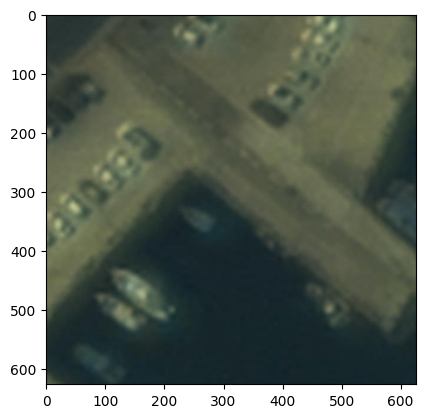

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# 저해상도 이미지 경로
lr_img_path = '/content/drive/MyDrive/lr_fin/08종달리.jpg'

# 저해상도 이미지 읽기 및 전처리
lr_img = cv2.imread(lr_img_path)  # 이미지를 읽음 (BGR 형식)
lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)  # RGB 형식으로 변환
print("저해상도 이미지 크기: {}".format(lr_img.shape))

plt.imshow(lr_img)  # 이미지 출력

# 이미지 정규화
lr_img = lr_img.astype(np.float32) / 255.0  # [0, 1] 사이로 정규화

# 모델 평가 모드
model.eval()

# 이미지를 모델 입력 형태로 변환
input_img = lr_img.transpose((2, 0, 1))  # (H, W, C) -> (C, H, W)
input_img = torch.tensor(input_img).unsqueeze(0).to(device)  # 배치 차원 추가, GPU로 전송

# 모델을 통해 고해상도 이미지 예측
with torch.no_grad():  # 기울기 계산 비활성화
    srcnn_img = model(input_img)

# 예측된 이미지를 다시 numpy 배열로 변환
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

# 고해상도 이미지 출력
plt.imshow(srcnn_img)
plt.show()


저해상도 이미지 크기: (640, 640, 3)


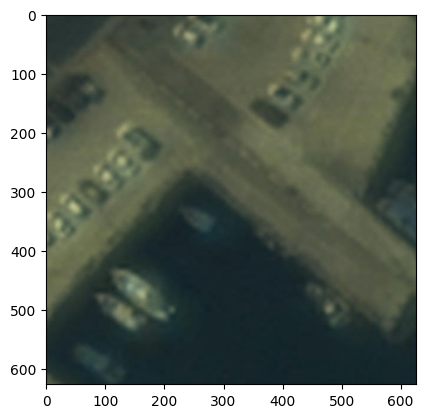

이미지를 저장했습니다: /content/drive/MyDrive/SRCNN/results/output_image_08종달리.jpg


In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# 저해상도 이미지 경로
lr_img_path = '/content/drive/MyDrive/lr_fin/08종달리.jpg'

# 저해상도 이미지 읽기 및 전처리
lr_img = cv2.imread(lr_img_path)  # 이미지를 읽음 (BGR 형식)
lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)  # RGB 형식으로 변환
print("저해상도 이미지 크기: {}".format(lr_img.shape))

plt.imshow(lr_img)  # 이미지 출력

# 이미지 정규화
lr_img = lr_img.astype(np.float32) / 255.0  # [0, 1] 사이로 정규화

# 모델 평가 모드
model.eval()

# 이미지를 모델 입력 형태로 변환
input_img = lr_img.transpose((2, 0, 1))  # (H, W, C) -> (C, H, W)
input_img = torch.tensor(input_img).unsqueeze(0).to(device)  # 배치 차원 추가, GPU로 전송

# 모델을 통해 고해상도 이미지 예측
with torch.no_grad():  # 기울기 계산 비활성화
    srcnn_img = model(input_img)

# 예측된 이미지를 다시 numpy 배열로 변환
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

# 고해상도로 복원된 이미지를 [0, 255]로 다시 변환 (정규화 해제)
srcnn_img = (srcnn_img * 255.0).clip(0, 255).astype(np.uint8)

# 고해상도 이미지 출력
plt.imshow(srcnn_img)
plt.show()

# 고해상도 이미지 저장 경로
output_path = '/content/drive/MyDrive/SRCNN/results/output_image_08종달리.jpg'

# 고해상도 이미지 저장 (RGB -> BGR 변환 후 저장)
cv2.imwrite(output_path, cv2.cvtColor(srcnn_img, cv2.COLOR_RGB2BGR))

print(f"이미지를 저장했습니다: {output_path}")


img shape: (256, 256, 3)


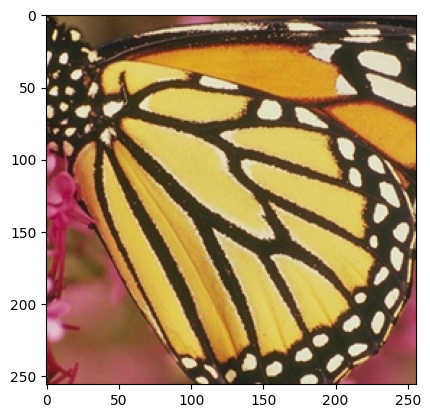

In [ ]:
hr_img_path = '/content/drive/MyDrive/SRCNN/Set5/butterfly.png'

hr_img = cv2.imread(hr_img_path)
hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
print("img shape: {}".format(hr_img.shape))

plt.imshow(hr_img)

hr_img = hr_img.astype(np.float32) / 255.0
temp_img = cv2.resize(hr_img, dsize=(0,0), fx = 1/upscale_factor, fy = 1/upscale_factor,interpolation = cv2.INTER_AREA)
bicubic_img = cv2.resize(temp_img, dsize=(0,0), fx = upscale_factor, fy = upscale_factor, interpolation = cv2.INTER_CUBIC)

model.eval()
input_img = bicubic_img.transpose((2,0,1))
input_img = torch.tensor(input_img).unsqueeze(0).to(device)

with torch.no_grad():
  srcnn_img = model(input_img)

srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose((1,2,0))
#srcnn_img = cv2.cvtColor(srcnn_img, cv2.COLOR_BGR2RGB)

저해상도 이미지 크기: (640, 640, 3)


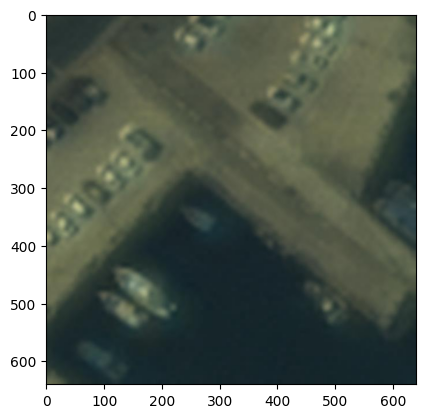

In [ ]:
# 저해상도 이미지 경로를 넣어야 함
lr_img_path = '/content/drive/MyDrive/lr_fin/08종달리.jpg'  # 저해상도 이미지 경로로 변경

lr_img = cv2.imread(lr_img_path)  # 저해상도 이미지를 읽음
lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)  # BGR -> RGB 변환
print("저해상도 이미지 크기: {}".format(lr_img.shape))

plt.imshow(lr_img)  # 저해상도 이미지 출력

# 이미지를 [0, 1]로 정규화
lr_img = lr_img.astype(np.float32) / 255.0

# SRCNN 모델을 사용해 고해상도 이미지로 변환
model.eval()
input_img = lr_img.transpose((2, 0, 1))  # (H, W, C) -> (C, H, W) 변환
input_img = torch.tensor(input_img).unsqueeze(0).to(device)  # 배치 차원 추가 후 GPU로 전송

with torch.no_grad():
    srcnn_img = model(input_img)  # 고해상도 이미지 예측

# 예측 결과를 다시 numpy 배열로 변환하여 후처리
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)


저해상도 이미지 크기: (640, 640, 3)


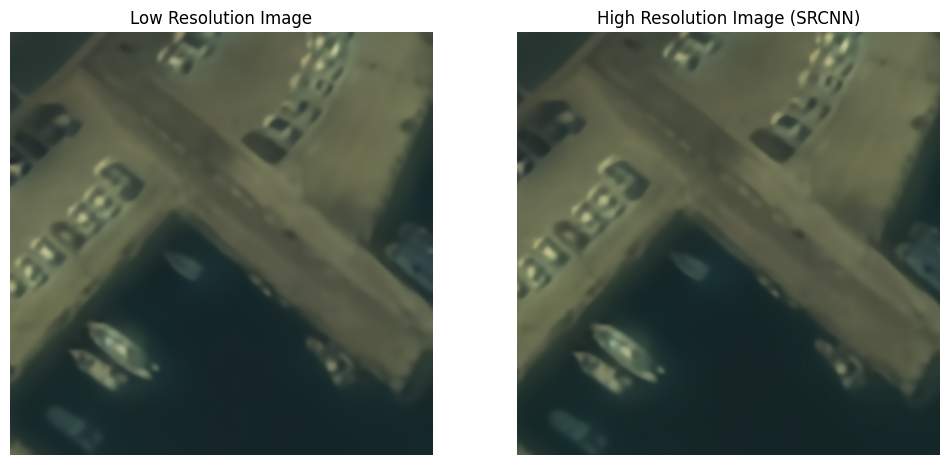

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# 저해상도 이미지 경로
lr_img_path = '/content/drive/MyDrive/NAFNet_results/deblur/08종달리_denoise_deblur.png'

# 저해상도 이미지 읽기 및 전처리
lr_img = cv2.imread(lr_img_path)  # 이미지를 읽음 (BGR 형식)
lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)  # RGB 형식으로 변환
print("저해상도 이미지 크기: {}".format(lr_img.shape))

# 이미지 정규화
lr_img = lr_img.astype(np.float32) / 255.0  # [0, 1]로 정규화

# 모델 평가 모드
model.eval()

# 이미지를 모델 입력 형태로 변환
input_img = lr_img.transpose((2, 0, 1))  # (H, W, C) -> (C, H, W)로 변환
input_img = torch.tensor(input_img).unsqueeze(0).to(device)  # 배치 차원 추가 후 GPU로 전송

# 모델을 통해 고해상도 이미지 예측
with torch.no_grad():
    srcnn_img = model(input_img)

# 예측된 이미지를 다시 numpy 배열로 변환
srcnn_img = srcnn_img.squeeze().cpu().numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

# 고해상도로 복원된 이미지를 [0, 255]로 변환 후 정수형으로 변경
srcnn_img = (srcnn_img * 255.0).clip(0, 255).astype(np.uint8)

# 두 이미지를 나란히 출력
plt.figure(figsize=(12, 6))

# 저해상도 이미지 출력
plt.subplot(1, 2, 1)
plt.imshow(lr_img)
plt.title("Low Resolution Image")
plt.axis("off")  # 축 숨김

# 고해상도 이미지 출력
plt.subplot(1, 2, 2)
plt.imshow(srcnn_img)
plt.title("High Resolution Image (SRCNN)")
plt.axis("off")  # 축 숨김

# 두 이미지 출력
plt.show()


##원본/bicubic/srcnn 비교

Text(0.5, 1.0, 'srcnn_img')

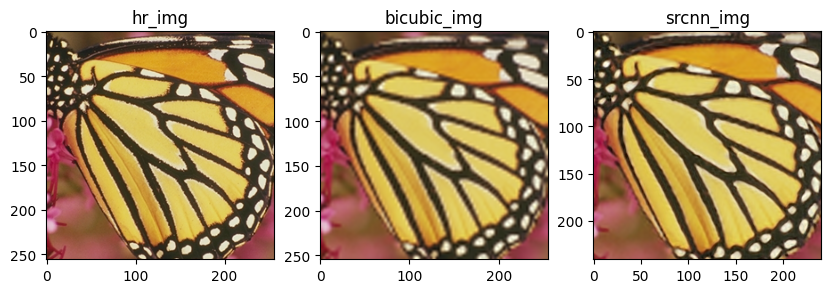

In [ ]:
fig, axes = plt.subplots(1,3, figsize = (10,5))

axes[0].imshow(hr_img)
axes[1].imshow(bicubic_img)
axes[2].imshow(np.squeeze(srcnn_img))

axes[0].set_title('hr_img')
axes[1].set_title('bicubic_img')
axes[2].set_title('srcnn_img')

##psnr 계산

In [ ]:
def PSNR(y_pred, y_ture):
    return 10. * torch.log10(1. / torch.mean((y_pred - y_ture) ** 2))

#NAFNet

###git clone

In [2]:
!git clone https://github.com/megvii-research/NAFNet /content/drive/MyDrive/NAFNet

fatal: destination path '/content/drive/MyDrive/NAFNet' already exists and is not an empty directory.


In [3]:
!pip install -r /content/drive/MyDrive/NAFNet/requirements.txt
# !python /content/drive/MyDrive/NAFNet/setup.py develop --no_cuda_ext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 14.4 MB/s eta 0:00:00


In [4]:
!pip install --upgrade pip setuptools

  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
  Using cached setuptools-75.1.0-py3-none-any.whl.metadata (6.9 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
Using cached setuptools-75.1.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 71.0.4
    Uninstalling setuptools-71.0.4:
      Successfully uninstalled setuptools-71.0.4
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [5]:
!pip install ninja

In [1]:
%cd /content/drive/MyDrive/NAFNet
!python setup.py develop --no_cuda_ext

/content/drive/MyDrive/NAFNet
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based to

###공식 깃허브

SSID -> Denoise

REDS -> Deblur

In [3]:
!python /content/drive/MyDrive/NAFNet/basicsr/demo.py -opt /content/drive/MyDrive/NAFNet/options/test/SIDD/NAFNet-width64.yml --input_path /content/drive/MyDrive/gaussianblur/deblur/08종달리_denoise.png --output_path /content/drive/MyDrive/gaussianblur/deblur/08종달리_denoise_deblur.png

Disable distributed.
/content/drive/MyDrive/NAFNet/basicsr/models/base_model.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_net = torch.load(
 load net keys <bui

In [2]:
!python /content/drive/MyDrive/NAFNet/basicsr/demo.py -opt /content/drive/MyDrive/NAFNet/options/test/REDS/NAFNet-width64.yml --input_path /content/drive/MyDrive/gaussianblur/08종달리_denoise.png --output_path /content/drive/MyDrive/gaussianblur/deblur/08종달리_denoise.png

Disable distributed.
/content/drive/MyDrive/NAFNet/basicsr/models/base_model.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_net = torch.load(
 load net keys <bui

In [ ]:
from PIL import Image

def resize_and_compress_image(input_path, output_path, max_size=640, compress_level=9):
    with Image.open(input_path) as img:
        img = img.convert("RGB")
        img.thumbnail((max_size, max_size))
        img.save(output_path, "PNG", compress_level=compress_level)

# 사용 예시
resize_and_compress_image('/content/drive/MyDrive/HAT/results/HAT_SRx4_ImageNet-LR/visualization/custom/08종달리해수욕장_deblur_HAT_SRx4_ImageNet-LR.png', '/content/drive/MyDrive/종달리해수욕장.png', max_size=640, compress_level=9)

구글링